### 00 packages

In [24]:
##################################################################################################
##################################################################################################

import numpy as np

import pandas as pd

import geopandas as gpd

import folium

import copy

import geopandas as gp

import networkx as nx

from sklearn.cluster import DBSCAN

from collections import defaultdict

from shapely.geometry import Point

from scipy.spatial import KDTree

from datetime import datetime, timedelta

import os

import matplotlib.pyplot as plt

import seaborn as sns

##################################################################################################
##################################################################################################

import warnings

warnings.filterwarnings('ignore')

### 01 match bus stops into the network

https://transitfeeds.com/p/action-buses/3

In [25]:
##################################################################################################
##################################################################################################

suburb_path="./01data/canberra_suburb"

suburb_data = gp.read_file(suburb_path+"/ACTGOV_DIVISION.shp")

suburb_data = suburb_data.to_crs(epsg=4326)

suburbs_with_intersections = gpd.sjoin(suburb_data, suburb_data, how='inner', predicate='intersects')

non_isolated_suburbs = suburbs_with_intersections[suburbs_with_intersections.ID_left != suburbs_with_intersections.ID_right]

non_isolated_suburb_ids = non_isolated_suburbs['ID_left'].unique()

non_isolated_suburbs = suburb_data.loc[suburb_data.ID.isin(non_isolated_suburb_ids)]

##################################################################################################
##################################################################################################

# GTFS path

gtfs_path="./01data/canberra"

##################################################################################################
##################################################################################################

abstracted_node_set=np.load("./02result/road_network/abstracted_node_set.npy")

abstracted_node_set=[tuple(node) for node in abstracted_node_set]

##################################################################################################
##################################################################################################

bus_stop_data = pd.read_csv(gtfs_path+'/stops.txt')

bus_stop_data = bus_stop_data[["stop_id","stop_name","stop_lat","stop_lon"]]

##################################################################################################
##################################################################################################

kdtree = KDTree(np.array(abstracted_node_set))

bus_stop_data['node']=bus_stop_data.apply(lambda x:abstracted_node_set[kdtree.query([x.stop_lat, x.stop_lon])[1]],axis=1)

bus_stop_data.to_csv("./02result/bus_data/abstracted_bus_stop_data.csv")

##################################################################################################
##################################################################################################

stop_node_dic = {}

for idx, row in bus_stop_data.iterrows():
    
    stop_node_dic[row.stop_id]=row.node

np.save('./02result/bus_data/stop_node_dic',stop_node_dic) 

##################################################################################################
##################################################################################################

network = folium.Map(location=[suburb_data.geometry.centroid.y.mean(),\
                               suburb_data.geometry.centroid.x.mean()],\
                     zoom_start=11,tiles='CartoDB positron')

folium.Choropleth(
    geo_data=non_isolated_suburbs[['geometry']],
    fill_color='blue',
    fill_opacity=0.1,
    name='Zone').add_to(network)

for idx,row in bus_stop_data.iterrows():
    
    folium.CircleMarker(location=[row.stop_lat,row.stop_lon], radius=3, color='blue', fill=True).add_to(network)
    
    folium.CircleMarker(location=row.node, radius=3, color='red', fill=True).add_to(network)
    
    folium.PolyLine([(row.stop_lat,row.stop_lon),row.node],\
                    color="black",\
                    weight=2.0,\
                    opacity=0.6).add_to(network)
    
network.save('./04html/04bus_stops_map.html')



### 03 bus schedules

In [26]:
##################################################################################################
##################################################################################################

route_data = pd.read_csv(gtfs_path+'/routes.txt')

route_data = route_data.loc[route_data.route_type==3]

route_data = route_data.reset_index(drop=True)

##################################################################################################
##################################################################################################

trip_data = pd.read_csv(gtfs_path+'/trips.txt')

trip_data = pd.merge(route_data[['route_id']],trip_data,on='route_id',how='left')

trip_data = trip_data[["route_id","trip_id"]]

trip_data = trip_data.loc[trip_data.trip_id.str.contains('Weekday')]

trip_data = trip_data.reset_index(drop=True)

##################################################################################################
##################################################################################################

schedule_data = pd.read_csv(gtfs_path+'/stop_times.txt')

route_schedule_data = copy.copy(schedule_data[["trip_id","stop_id"]])

route_schedule_data = route_schedule_data.groupby('trip_id')['stop_id'].apply(list).reset_index()

##################################################################################################
##################################################################################################

time_schedule_data = copy.copy(schedule_data[["trip_id","arrival_time"]])

fmt = '%H:%M:%S'

time_schedule_data['arrival_time']=time_schedule_data.apply(lambda x:datetime.strptime(x.arrival_time,fmt) if int(x.arrival_time[:2])<24 else datetime.strptime(str(int(x.arrival_time[:2])-24)+x.arrival_time[2:],fmt)+ timedelta(days=1),axis=1)
                                                            
time_schedule_data = time_schedule_data.groupby('trip_id')['arrival_time'].apply(list).reset_index()                                                  
                     
time_schedule_data['travel_time']=time_schedule_data.apply(lambda x:[max(int((x.arrival_time[i]-x.arrival_time[i-1]).total_seconds()/60),1) for i in range(1,len(x.arrival_time),1)],axis=1)

##################################################################################################
##################################################################################################

bus_schedule_data = pd.merge(trip_data,route_schedule_data,on='trip_id',how='left')

bus_schedule_data = pd.merge(bus_schedule_data,time_schedule_data[['trip_id','travel_time']],on='trip_id',how='left')

bus_schedule_data['stop_number']=bus_schedule_data.apply(lambda x:len(x.stop_id),axis=1)

##################################################################################################
##################################################################################################

bus_schedule_data = bus_schedule_data.drop_duplicates(subset=["route_id"], keep='first')

bus_schedule_data = bus_schedule_data.reset_index(drop=True)

bus_schedule_data['schedule']=bus_schedule_data.apply(lambda x:[stop_node_dic[s] for s in x.stop_id],axis=1)

bus_schedule_data=bus_schedule_data[['route_id', 'trip_id', 'stop_id', \
                                     'stop_number','schedule','travel_time']]

bus_schedule_data.to_csv("./02result/bus_data/abstracted_bus_schedule_data.csv")

##################################################################################################
##################################################################################################


network = folium.Map(location=[suburb_data.geometry.centroid.y.mean(),\
                               suburb_data.geometry.centroid.x.mean()],\
                     zoom_start=11,tiles='CartoDB positron')

for idx,row in bus_schedule_data.iterrows():
    
    folium.Circle(
            radius=10,
            location=row.schedule[0],
            color='red',
            fill=True).add_to(network)
    
    for j in range(1,len(row.schedule),1):
        
        folium.Circle(
            radius=10,
            location=row.schedule[j],
            color='red',
            fill=True).add_to(network)
        
        folium.PolyLine([row.schedule[j-1],row.schedule[j]],\
                    color="black",\
                    weight=2.0,\
                    opacity=0.6).add_to(network)


network.save('./04html/05bus_schedules_map.html')



In [27]:
bus_schedule_data

,route_id,trip_id,stop_id,stop_number,schedule,travel_time
0,2-10612,59942387-2023-COMBNXT-Weekday-05,"[4221, 4932, 4220, 5102, 4980, 4899, 5026, 604...",62,"[(-35.19078626001012, 149.0361057353301), (-35...","[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,3-10612,59942412-2023-COMBNXT-Weekday-05,"[3353, 3467, 3469, 3070, 3072, 3029, 3031, 303...",46,"[(-35.307807201175216, 149.18865830338726), (-...","[3, 1, 7, 1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 2, 7, ..."
2,4-10612,59942468-2023-COMBNXT-Weekday-05,"[4479, 5501, 5511, 5521, 3441, 4979, 4005, 481...",27,"[(-35.23974144539833, 149.06113665595473), (-3...","[2, 3, 1, 1, 2, 1, 2, 1, 7, 2, 1, 1, 1, 1, 11,..."
3,5-10612,59943074-2023-COMBNXT-Weekday-05,"[1217, 2699, 2697, 1078, 1079, 1081, 1083, 101...",34,"[(-35.456783560236076, 149.09321167224223), (-...","[1, 1, 4, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, ..."
4,6-10612,59943158-2023-COMBNXT-Weekday-05,"[4529, 3418, 3003, 8888, 3258, 3260, 2259, 237...",30,"[(-35.27725030787086, 149.12524444031186), (-3...","[3, 1, 3, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...
60,181-10612,59946080-2023-COMBNXT-Weekday-05,"[4529, 3420, 3003, 8888, 2247, 1418, 1342, 137...",38,"[(-35.27725030787086, 149.12524444031186), (-3...","[5, 2, 1, 2, 17, 1, 4, 1, 2, 4, 1, 1, 1, 1, 1,..."
61,182-10612,59946087-2023-COMBNXT-Weekday-05,"[4529, 3420, 3004, 3005, 3006, 3007, 3008, 300...",23,"[(-35.27725030787086, 149.12524444031186), (-3...","[5, 1, 2, 1, 1, 2, 1, 3, 3, 1, 1, 1, 1, 1, 1, ..."
62,901-10612,59946052-2023-COMBNXT-Weekday-05,"[941, 5501, 5513, 4146, 4144, 1736, 1738, 4008...",27,"[(-35.23912813172353, 149.06096301733527), (-3...","[2, 2, 2, 1, 2, 1, 3, 1, 1, 1, 2, 3, 1, 1, 3, ..."
63,902-10612,59946064-2023-COMBNXT-Weekday-05,"[2769, 2091, 2378, 2380, 2379, 2382, 5100, 261...",46,"[(-35.34330275997532, 149.08770043591073), (-3...","[2, 1, 1, 1, 2, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, ..."


### 04 time schedule of bus routes

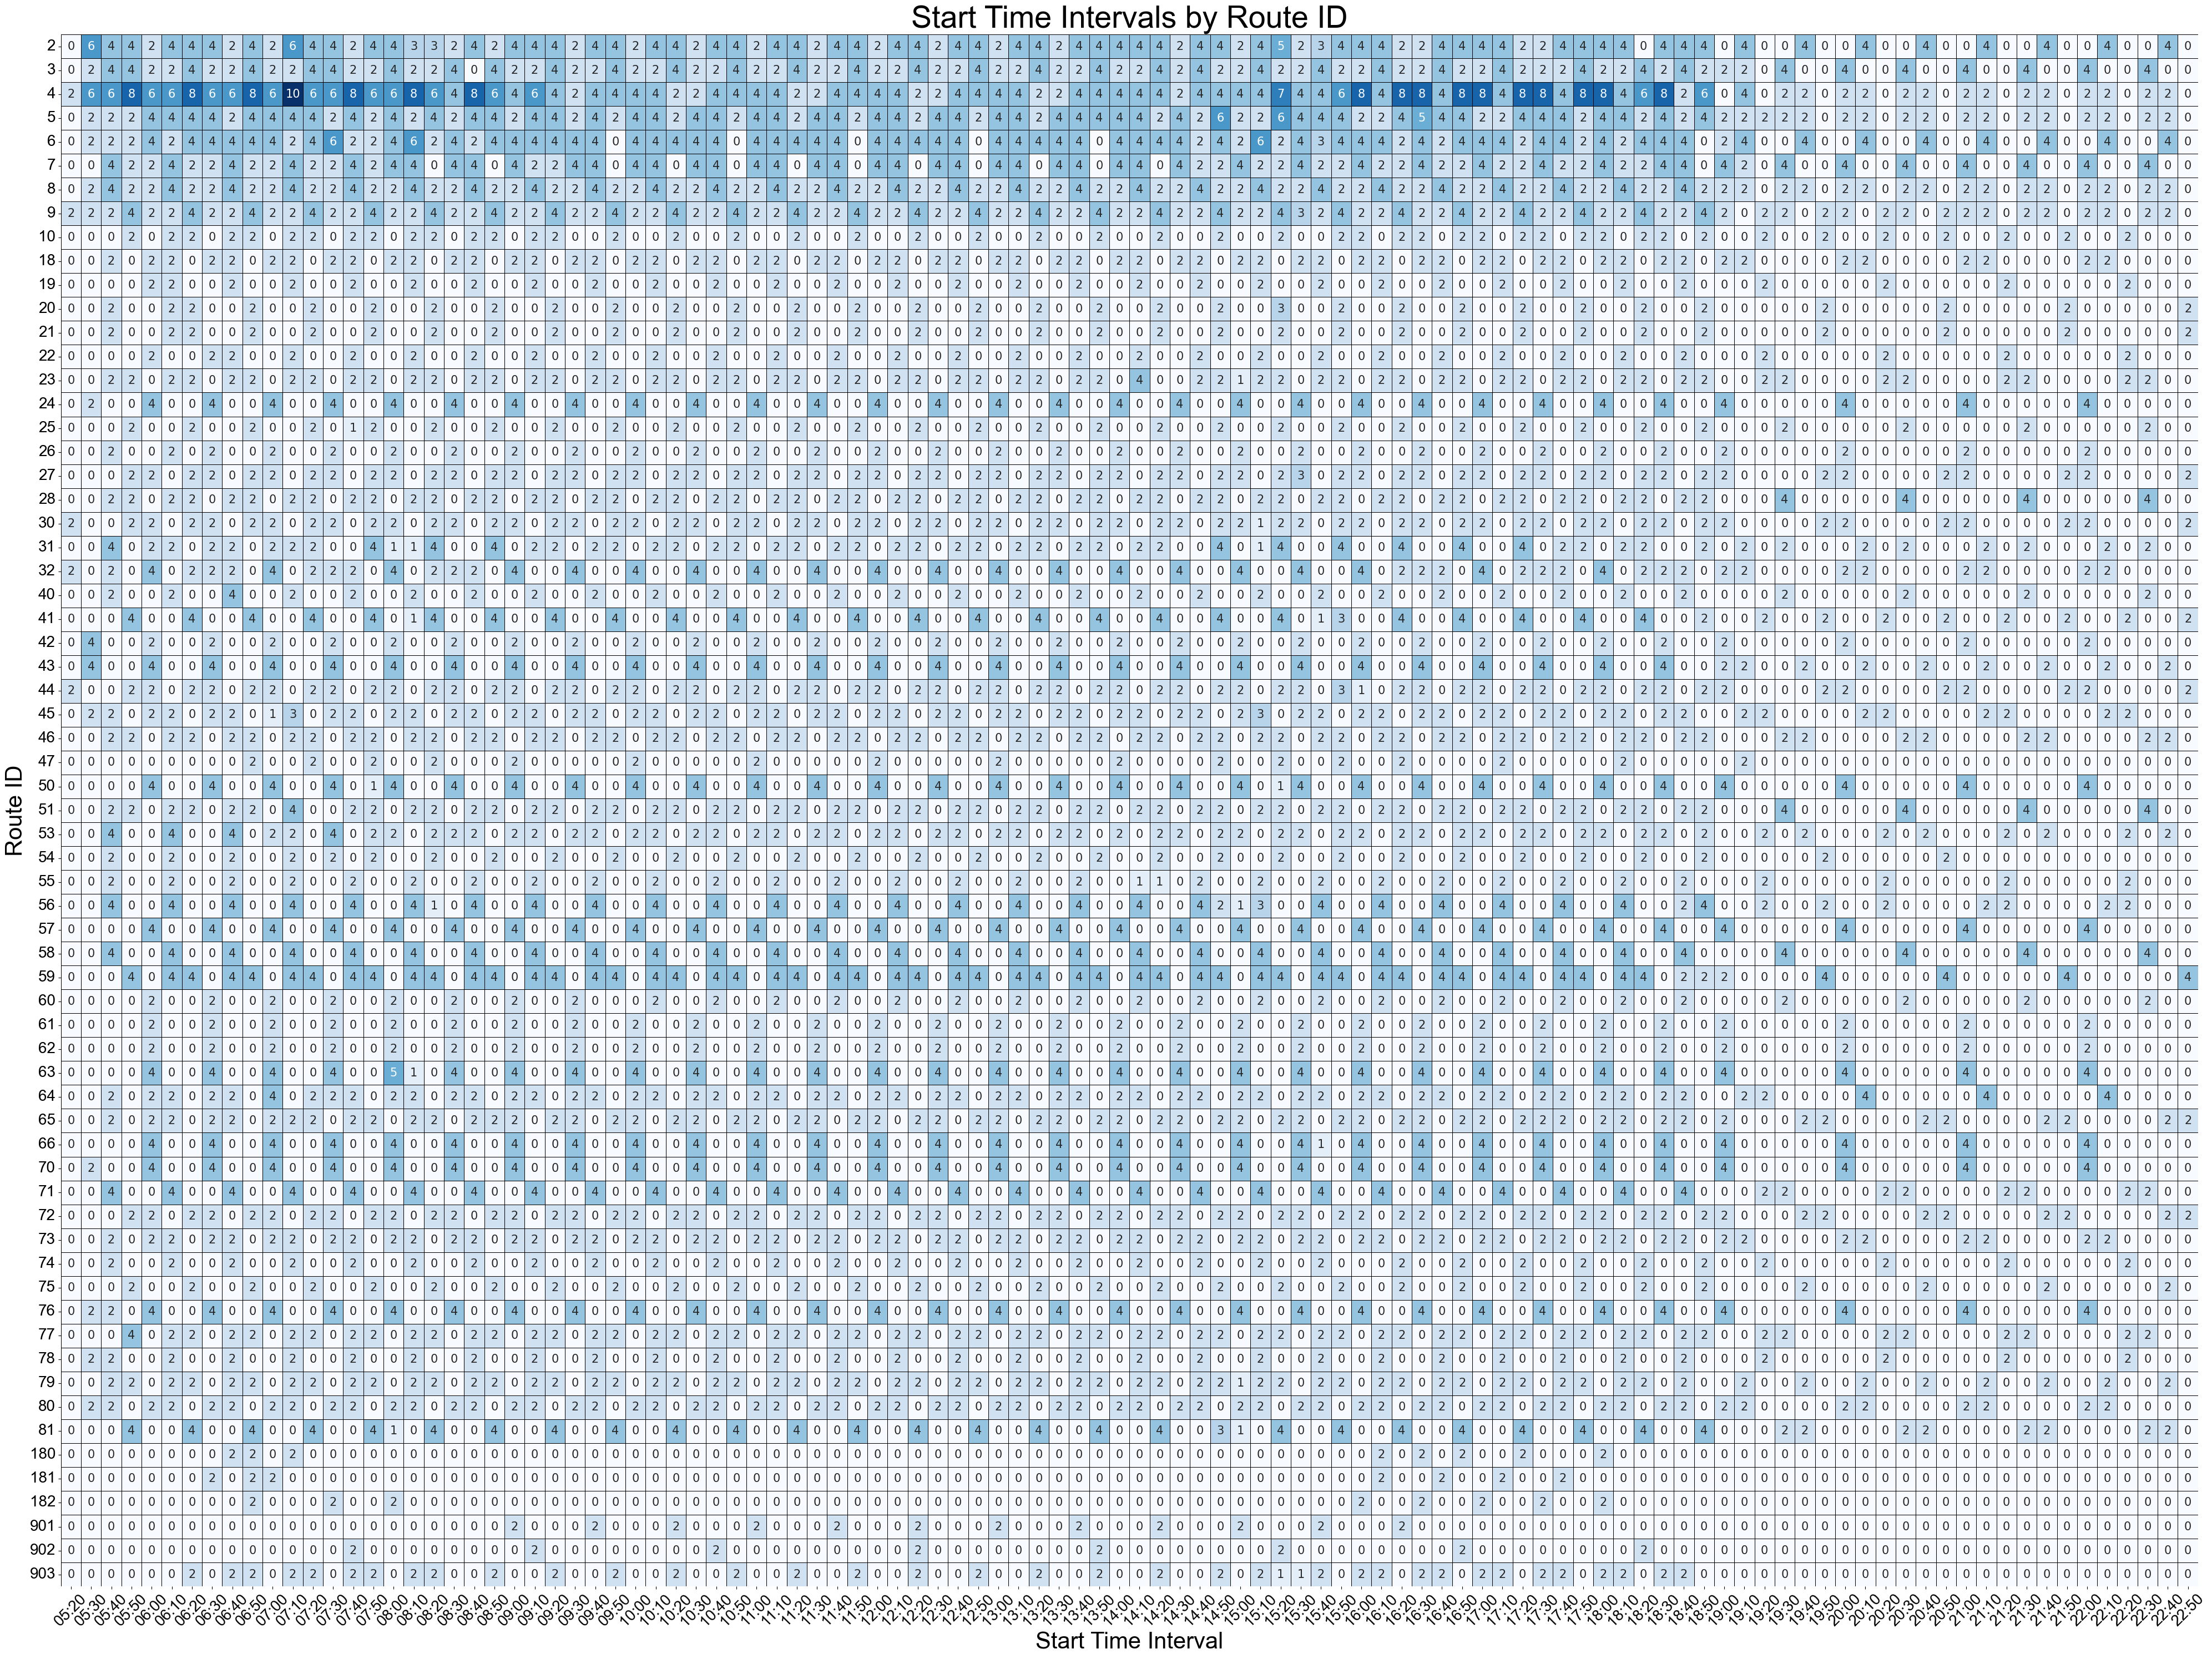

In [28]:
##################################################################################################
##################################################################################################

detailed_schedule_data = pd.merge(trip_data,route_schedule_data,on='trip_id',how='left')

detailed_schedule_data = pd.merge(detailed_schedule_data,time_schedule_data[['trip_id','arrival_time']],on='trip_id',how='left')

##################################################################################################
##################################################################################################

detailed_schedule_data['start_time']=detailed_schedule_data.apply(lambda x:x.arrival_time[0],axis=1)

detailed_schedule_data=detailed_schedule_data[['route_id','start_time']]

##################################################################################################
##################################################################################################

def get_10_min_interval(timestamp):
    intervals = pd.date_range(start=timestamp.date(), periods=144, freq='10T')
    return intervals.get_loc(timestamp.floor('10T'))

# Apply the function to create a new column with 10-minute intervals
detailed_schedule_data['start_time_interval'] = detailed_schedule_data['start_time'].apply(get_10_min_interval)

##################################################################################################
##################################################################################################

detailed_schedule_data=detailed_schedule_data.groupby('route_id')['start_time_interval'].apply(list).reset_index() 

detailed_schedule_data['start_time_interval'] = detailed_schedule_data.apply(lambda x:sorted(x.start_time_interval),axis=1)

detailed_schedule_data['route_id']=detailed_schedule_data.apply(lambda x:int(x.route_id.split('-')[0]),axis=1)


##################################################################################################
##################################################################################################

detailed_schedule_data.to_csv("./02result/bus_data/detailed_bus_schedule_data.csv")

##################################################################################################
##################################################################################################

# Explode the lists into separate rows
exploded_data = detailed_schedule_data.explode('start_time_interval')

# Create a pivot table for the heatmap
pivot_table = exploded_data.pivot_table(index='route_id', columns='start_time_interval', aggfunc='size', fill_value=0)

# Sort the pivot table by route_id to ensure the vertical axis is ordered from small to large
pivot_table_sorted = pivot_table.sort_index()

# Convert start_time_interval numbers to actual time strings
time_labels = {i: f"{i//6:02d}:{(i%6)*10:02d}" for i in pivot_table_sorted.columns}

# Rename the columns in the pivot table to the time labels
pivot_table_sorted.columns = pivot_table_sorted.columns.map(time_labels)


##########################################################################################
##########################################################################################
    
font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 30}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

figure, axs = plt.subplots(1,1,figsize=(40, 30))

labels = axs.get_xticklabels() + axs.get_yticklabels()

[label.set_fontsize(20) for label in labels]

[label.set_fontname('Arial') for label in labels]

##########################################################################################
##########################################################################################
    

# Plot the heatmap with time labels

sns.heatmap(pivot_table_sorted, annot=True, fmt='d', cmap='Blues', cbar=False,ax=axs, annot_kws={"size": 15},linewidths=0.5, linecolor='black')

##########################################################################################
##########################################################################################
   
axs.set_title('Start Time Intervals by Route ID',font_title)

axs.set_xlabel('Start Time Interval',font_label)

axs.set_ylabel('Route ID',font_label)

axs.tick_params(axis='x', rotation=45)

axs.tick_params(axis='y', rotation=0)

##########################################################################################
##########################################################################################

# Display the plot

plt.tight_layout()

current_fig = plt.gcf() 

current_fig.savefig('./05figure/07start_time_distribution.eps', format='eps', dpi=1000, bbox_inches = 'tight')

##########################################################################################
##########################################################################################

plt.show()

### 04 Distribution of total stops by bus routes 

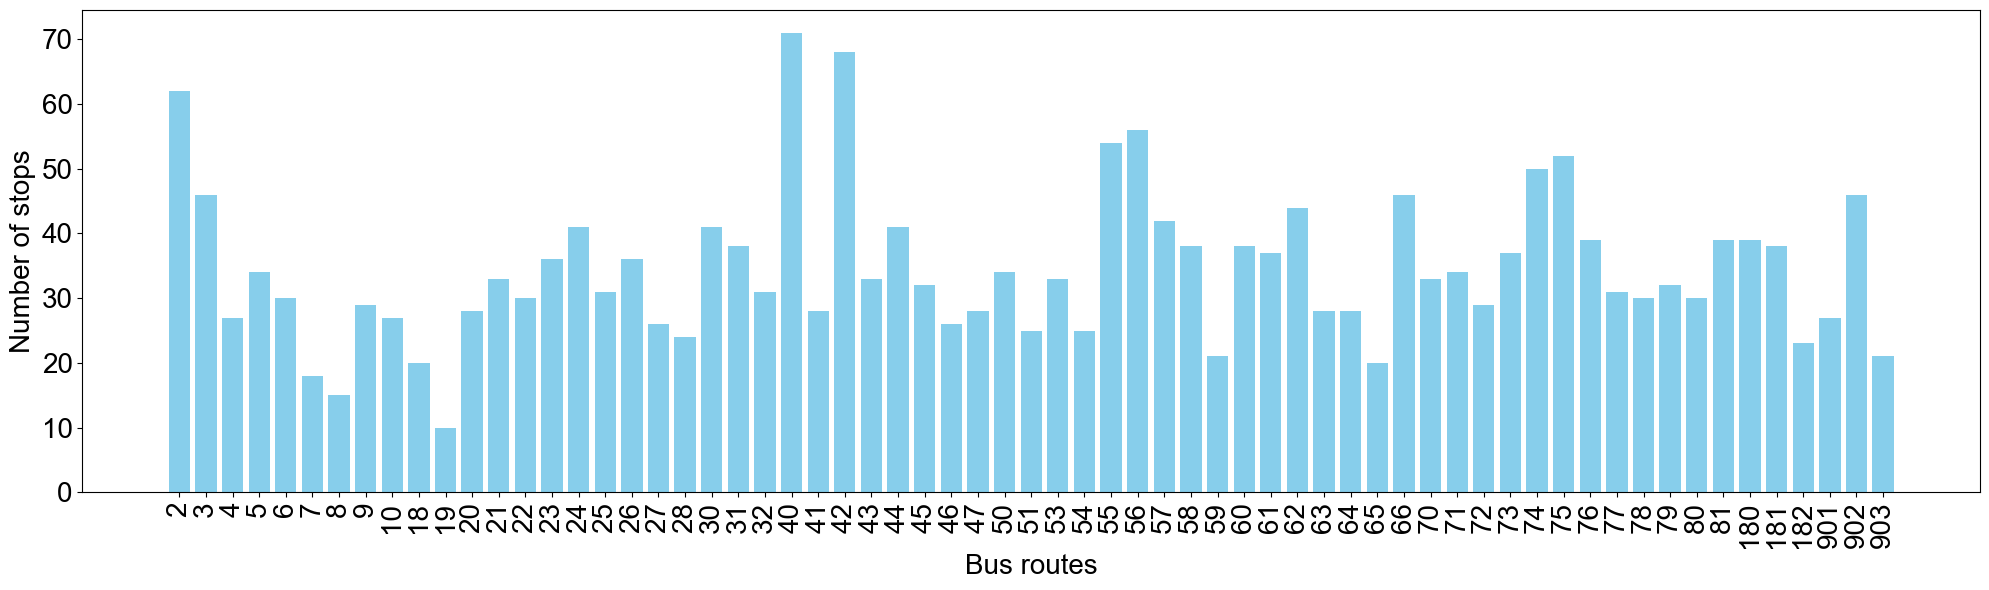

In [29]:
bus_schedule_data['displayed_id']=bus_schedule_data.apply(lambda x:x.route_id.split('-')[0],axis=1)

##########################################################################################
##########################################################################################
    
font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 20}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

figure, axs = plt.subplots(1,1,figsize=(20,6))

##########################################################################################
##########################################################################################
    
labels = axs.get_xticklabels() + axs.get_yticklabels()

[label.set_fontsize(20) for label in labels]

[label.set_fontname('Arial') for label in labels]

axs.bar(bus_schedule_data['displayed_id'], bus_schedule_data['stop_number'], color='skyblue')

# Adding labels and title

axs.set_xlabel('Bus routes',font_label)

axs.set_ylabel('Number of stops',font_label)

axs.tick_params(axis='x', rotation=90)


# Display the plot

plt.tight_layout()

current_fig = plt.gcf() 

current_fig.savefig('./05figure/01distribution_of_stops.eps', format='eps', dpi=1000, bbox_inches = 'tight')

##########################################################################################
##########################################################################################

plt.show()

### 05 aggregated data

In [59]:
agg_bus_data=copy.copy(bus_schedule_data)

agg_bus_data=agg_bus_data[['route_id','schedule','travel_time']]

agg_bus_data['route_id']=agg_bus_data.apply(lambda x:int(x.route_id.split('-')[0]),axis=1)

agg_bus_data=agg_bus_data.merge(detailed_schedule_data,on='route_id',how='left')

agg_bus_data = agg_bus_data.explode('start_time_interval').reset_index(drop=True)

agg_bus_data['start_time']=agg_bus_data.apply(lambda x:np.random.randint((x.start_time_interval-1)*10,x.start_time_interval*10),axis=1)

agg_bus_data=agg_bus_data.sort_values(by=['start_time'],ignore_index=True)

agg_bus_data['trip_id']=agg_bus_data.index

agg_bus_data=agg_bus_data[['trip_id','route_id','start_time','schedule','travel_time']]

agg_bus_data=agg_bus_data.rename(columns={"schedule":"stops"})

# agg_bus_data.to_csv("./02result/bus_data/agg_bus_data.csv")

# Process the dataset to calculate departure and arrival times for each stop in each trip.

def calculate_times_fixed(row):
    """
    Calculate arrival and departure times for each stop in a trip.
    Assumes travel_time is already a list.
    """
    travel_times = row['travel_time']  # Travel times are already lists
    start_time = row['start_time']  # Initial time for the first stop
    stop_time = 2  # Time spent at each stop (in minutes)

    # Initialize arrival and departure times
    arrival_times = []
    departure_times = []

    current_time = start_time
    for travel_time in travel_times:
        arrival_times.append(current_time)  # Arrival time at current stop
        departure_times.append(current_time + stop_time)  # Departure time after stop
        current_time += travel_time + stop_time  # Move to the next stop

    # Add the last stop's arrival and departure times
    arrival_times.append(current_time)
    departure_times.append(current_time + stop_time)

    return arrival_times, departure_times

# Apply the function to each row and expand the results into new columns

agg_bus_data[['arrival_times', 'departure_times']] = agg_bus_data.apply(
    lambda row: pd.Series(calculate_times_fixed(row)),
    axis=1
)

agg_bus_data=agg_bus_data[['trip_id','route_id','start_time','stops','arrival_times','departure_times']]

agg_bus_data.to_csv("./02result/bus_data/agg_bus_data.csv")

agg_bus_data

,trip_id,route_id,start_time,stops,arrival_times,departure_times
0,0,4,310,"[(-35.23974144539833, 149.06113665595473), (-3...","[310, 314, 319, 322, 325, 329, 332, 336, 339, ...","[312, 316, 321, 324, 327, 331, 334, 338, 341, ..."
1,1,9,311,"[(-35.23974144539833, 149.06113665595473), (-3...","[311, 314, 319, 322, 325, 329, 333, 336, 339, ...","[313, 316, 321, 324, 327, 331, 335, 338, 341, ..."
2,2,32,312,"[(-35.24005607296462, 149.05961644698985), (-3...","[312, 316, 320, 324, 328, 331, 334, 340, 343, ...","[314, 318, 322, 326, 330, 333, 336, 342, 345, ..."
3,3,30,312,"[(-35.24005607296462, 149.05961644698985), (-3...","[312, 316, 320, 323, 326, 330, 333, 336, 340, ...","[314, 318, 322, 325, 328, 332, 335, 338, 342, ..."
4,4,44,313,"[(-35.24097939900908, 149.06887422573715), (-3...","[313, 317, 321, 325, 329, 332, 335, 338, 342, ...","[315, 319, 323, 327, 331, 334, 337, 340, 344, ..."
...,...,...,...,...,...,...
7839,7839,72,1367,"[(-35.414745875068895, 149.06589329876186), (-...","[1367, 1371, 1374, 1377, 1380, 1385, 1388, 139...","[1369, 1373, 1376, 1379, 1382, 1387, 1390, 139..."
7840,7840,20,1367,"[(-35.184769913369905, 149.13709231285029), (-...","[1367, 1371, 1375, 1379, 1382, 1385, 1388, 139...","[1369, 1373, 1377, 1381, 1384, 1387, 1390, 139..."
7841,7841,59,1369,"[(-35.27725030787086, 149.12524444031186), (-3...","[1369, 1375, 1378, 1382, 1385, 1388, 1392, 139...","[1371, 1377, 1380, 1384, 1387, 1390, 1394, 139..."
7842,7842,65,1369,"[(-35.34330275997532, 149.08770043591073), (-3...","[1369, 1379, 1382, 1385, 1388, 1391, 1394, 139...","[1371, 1381, 1384, 1387, 1390, 1393, 1396, 140..."
